# Spam Message Classifier using RoBERTa

## Introduction

Spam messages are a widespread issue across digital communication platforms, disrupting user experience and trust. This project focuses on building a **spam message classifier** using **RoBERTa**, a state-of-the-art transformer model for natural language understanding.

We use the **SMS Spam Collection Dataset** to fine-tune RoBERTa for binary spam classification. This provides a strong and generalized spam detection model suitable for various text-based environments.

---

## Objectives

- Preprocess and clean SMS messages
- Fine-tune a pre-trained RoBERTa model
- Evaluate model performance using precision, recall, and F1-score
- Save and prepare the trained model for future integration

---

## 📖 Dataset

**Sources**: 
1. **[SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)** from UCI Machine Learning Repository
2. **[SMS Phishing Dataset](https://data.mendeley.com/datasets/f45bkkt8pr/1)** by Sandhya Mishra & Devpriya Soni (2022)

**Combined Dataset Statistics**:
- **Total Messages**: 11,498 (entire combined dataset)
- **Ham Messages**: 9,669 (84.1%)
- **Spam Messages**: 1,829 (15.9%)
- **Average Message Length**: ~80 characters
- **Language**: English

**Dataset Split**:
- **Training Set**: 70% (~8,048 messages) - used for model training
- **Validation Set**: 15% (~1,725 messages) - used for hyperparameter tuning
- **Test Set**: 15% (~1,725 messages) - used for final evaluation (unseen data)

**Dataset Details**:
- **UCI SMS Spam**: Classic SMS spam detection dataset with ham/spam labels
- **Mendeley SMS Phishing**: Modern phishing detection dataset including smishing attacks
- **Combined Approach**: Merged datasets for comprehensive spam and phishing detection

**Preprocessing Steps**:
1. Label encoding (ham → 0, spam → 1, smishing → 1)
2. Text cleaning and normalization with Discord-specific preprocessing
3. Dataset merging and deduplication
4. Train/validation/test split (70/15/15)
5. Tokenization with RoBERTa tokenizer
6. Dynamic padding and truncation

---

## Model: RoBERTa

We fine-tune a pre-trained `roberta-base` model using Hugging Face Transformers. The model is trained on the processed SMS dataset with a binary classification head.

---

## Evaluation Metrics

We evaluate the model using standard classification metrics:

- **Precision**
- **Recall**
- **F1-score**
- **Accuracy**

### Acceptance Criteria

To ensure the model's reliability in real-world deployment, we define the following criterion:

> **The model will be considered acceptable if the F1-score for the `spam` class exceeds 0.95 on the test dataset.**

This threshold ensures the classifier effectively balances **precision** and **recall** for detecting spam, minimizing both false positives and false negatives.

---

## Output

The trained model, tokenizer, and preprocessing pipeline are saved in Hugging Face format, ready for inference or deployment.

You can find the trained model here:  
👉 **[roshana1s/spam-message-classifier on Hugging Face](https://huggingface.co/roshana1s/spam-message-classifier)**

---

## Integration with Amy (Discord Bot)

This spam classifier will be integrated into **Amy** — an intelligent Discord bot capable of:

- Detecting spam messages in real-time using this RoBERTa-based model
- Identifying toxic or harmful messages (via a **separate toxicity detection model**)

This project serves as the core backend for Amy’s moderation capabilities in Discord servers.

---

## Preparing the tools

In [1]:
!pip install transformers datasets optuna scikit-learn matplotlib seaborn pandas torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [2]:
# General libraries
import pandas as pd
import numpy as np
import random

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# Hugging Face Transformers
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

# Dataset
from datasets import Dataset

# PyTorch (used under the hood by transformers)
import torch
from torch import nn

# Optuna for hyperparameter tuning
import optuna

import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath('..'))

In [3]:
import re

def preprocess_text(text: str) -> str:
    text = re.sub(r"(https?:\/\/)?(www\.)?(discord\.(gg|io|me|li)|discordapp\.com\/invite)\/\S+", "<DISCORD_INVITE>", text)  # Discord invites first
    text = re.sub(r"(https?://\S+|www\.\S+)", "<URL>", text)  # URLs
    text = re.sub(r"<@!?\d+>", "<USER>", text)                # Mentions
    text = re.sub(r"<a?:\w+:\d+>", "<EMOJI>", text)           # Emojis
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

## Load Data

### Load Dataset 1 - UCI SMS Spam dataset

In [62]:
df1 = pd.read_csv("/content/data/sms_spam_uci.csv", encoding="latin1")
df1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [63]:
df1 = df1[['v1', 'v2']]  # Keep only label and message
df1.columns = ['label', 'text']  # Rename for consistency
df1.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Load Dataset 2

In [64]:
df2 = pd.read_csv("/content/data/Dataset_5971.csv")
df2.head()

,LABEL,TEXT,URL,EMAIL,PHONE
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,No,No,No
1,ham,What's up? Do you want me to come online? If y...,No,No,No
2,ham,So u workin overtime nigpun?,No,No,No
3,ham,"Also sir, i sent you an email about how to log...",No,No,No
4,Smishing,Please Stay At Home. To encourage the notion o...,No,No,No


In [65]:
df2 = df2[['LABEL', 'TEXT']]  # Keep only label and message
df2.columns = ['label', 'text']  # Rename for consistency
df2.head()

,label,text
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...
1,ham,What's up? Do you want me to come online? If y...
2,ham,So u workin overtime nigpun?
3,ham,"Also sir, i sent you an email about how to log..."
4,Smishing,Please Stay At Home. To encourage the notion o...


In [66]:
# Make Smishing as spam as well
df2['label'] = df2['label'].apply(lambda x: 'spam' if x == 'Smishing' else x)
df2.head()

,label,text
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...
1,ham,What's up? Do you want me to come online? If y...
2,ham,So u workin overtime nigpun?
3,ham,"Also sir, i sent you an email about how to log..."
4,spam,Please Stay At Home. To encourage the notion o...


In [67]:
# Merge df1 and df2 as df
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [68]:
df.tail()

,label,text
11538,ham,:( but your not here....
11539,ham,Becoz its &lt;#&gt; jan whn al the post ofic...
11540,ham,Its a valentine game. . . send dis msg to all ...
11541,ham,We r outside already.
11542,ham,The Xmas story is peace.. The Xmas msg is love...


In [71]:
# Convert labels to numbers
# Convert spam/ham to 1/0
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,text
0,0.0,"Go until jurong point, crazy.. Available only ..."
1,0.0,Ok lar... Joking wif u oni...
2,1.0,Free entry in 2 a wkly comp to win FA Cup fina...
3,0.0,U dun say so early hor... U c already then say...
4,0.0,"Nah I don't think he goes to usf, he lives aro..."


In [72]:
df["label"].value_counts()

,count
label,
0.0,9669
1.0,1829


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11543 entries, 0 to 11542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   11498 non-null  float64
 1   text    11543 non-null  object 
dtypes: float64(1), object(1)
memory usage: 180.5+ KB


In [74]:
df.isna().sum()

,0
label,45
text,0


In [75]:
# Drop rows with missing labels
df.dropna(subset=['label'], inplace=True)

# Verify that there are no more missing values in the 'label' column
print(df.isna().sum())

label    0
text     0
dtype: int64


In [77]:
# Make label to int
df["label"] = df["label"].astype(int)
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


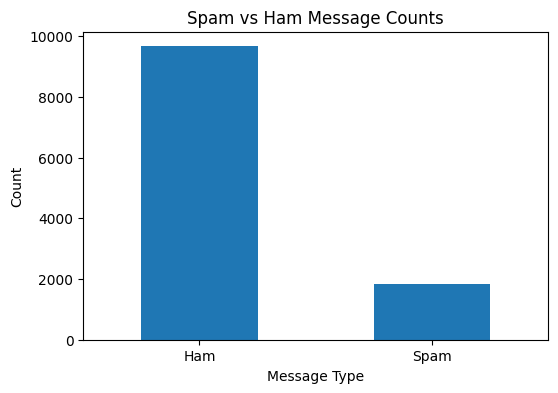

In [78]:
df["label"].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("Spam vs Ham Message Counts")
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=['Ham', 'Spam'], rotation=0)
plt.show()

We can clearly see, there is class imbalance between `spam` and `ham`.

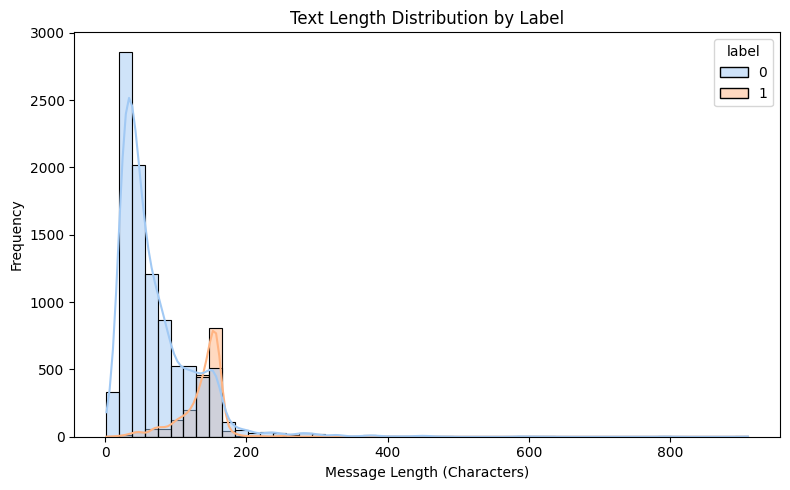

In [79]:
df["len"] = df["text"].apply(len)

# Plot text length distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="len", hue='label', bins=50, kde=True, palette='pastel')
plt.title("Text Length Distribution by Label")
plt.xlabel("Message Length (Characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show();

## Clean Data

In [80]:
df["text"] = df["text"].apply(preprocess_text)

In [81]:
df

,label,text,len
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
11538,0,:( but your not here....,24
11539,0,Becoz its &lt;#&gt; jan whn al the post ofice ...,108
11540,0,Its a valentine game. . . send dis msg to all ...,150
11541,0,We r outside already.,21


## Split Data

In [82]:
# Split data - preserve class distribution
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df['label']  # Maintain class balance in splits
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

In [83]:
train_df.shape, val_df.shape, test_df.shape

((8048, 3), (1725, 3), (1725, 3))

In [84]:
train_df["label"].value_counts()

,count
label,
0,6768
1,1280


In [85]:
val_df["label"].value_counts()

,count
label,
0,1450
1,275


In [86]:
test_df["label"].value_counts()

,count
label,
0,1451
1,274


In [87]:
train_df

,label,text,len
11294,0,"Thank you. And by the way, I just lost.",39
159,1,You are a winner U have been specially selecte...,146
3089,0,Am going to take bath ill place the key in win...,52
5980,0,Gudnite....tc...practice going on,33
3954,0,I knew it... U slept v late yest? Wake up so l...,52
...,...,...,...
10820,1,3. You have received your mobile content. Enjoy,47
8210,0,Yes i have. So that's why u texted. Pshew...mi...,63
917,0,"When people see my msgs, They think Iam addict...",148
7135,0,It will stop on itself. I however suggest she ...,111


We know that in this dataset, class imbalance is high. So, we need to have weighted trainer for that.

## Compute Class Weights

Let's compute class weights, then we can have a weighted loss function with computed class weights.

In [88]:
# Calculate weights based on TRAINING SET only
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

print(f"Class weights: {class_weights}")

# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

Class weights: [0.59456265 3.14375   ]


## Tokenization

In [89]:
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

In [90]:
def tokenize_function(batch):
    try:
        return tokenizer(
            batch['text'],
            truncation=True,
            max_length=128,
            padding=False,
            return_attention_mask=True
        )
    except Exception as e:
        print(f"Tokenization error: {e}")
        raise

In [91]:
# 1. Select only necessary columns
train_df = train_df[['label', 'text']]
val_df = val_df[['label', 'text']]
test_df = test_df[['label', 'text']]

# 2. Convert to Dataset objects (with proper validation)
train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
val_dataset = Dataset.from_pandas(val_df, preserve_index=False)
test_dataset = Dataset.from_pandas(test_df, preserve_index=False)

In [92]:
# 3. Apply tokenization
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']  # Remove original text after tokenization
)

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

tokenized_test = test_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text']
)

# 4. Sort only training set by length
tokenized_train = tokenized_train.add_column(
    "length",
    [len(x) for x in tokenized_train["input_ids"]]
).sort("length")

# Final datasets
train_dataset = tokenized_train
val_dataset = tokenized_val
test_dataset = tokenized_test

Map:   0%|          | 0/8048 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [93]:
tokenized_train

Dataset({
    features: ['label', 'input_ids', 'attention_mask', 'length'],
    num_rows: 8048
})

In [94]:
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',  # Pad to longest in batch
    max_length=128,  # Safety cap
    return_tensors="pt"
)

## Custom Trainer to use a weighted loss

In [95]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(kwargs['args'].device)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights, label_smoothing=0.1)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

## Compute metrics function

In [96]:
def compute_metrics(eval_pred):
    """Robust metrics for imbalanced binary classification"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Essential metrics (all weighted by class support)
    metrics = {
        'accuracy': accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'precision_weighted': precision_score(labels, predictions, average='weighted'),
        'recall_weighted': recall_score(labels, predictions, average='weighted'),
    }

    # Class-specific metrics
    metrics.update({
        # Spam class (label=1)
        'spam_precision': precision_score(labels, predictions, pos_label=1),
        'spam_recall': recall_score(labels, predictions, pos_label=1),
        'spam_f1': f1_score(labels, predictions, pos_label=1),

        # Ham class (label=0)
        'ham_precision': precision_score(labels, predictions, pos_label=0),
        'ham_recall': recall_score(labels, predictions, pos_label=0),
    })

    # Confusion matrix breakdown
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    metrics.update({
        'confusion_matrix': {
            'true_negatives': int(tn),  # Correct hams
            'false_positives': int(fp), # Hams misclassified as spam (bad)
            'false_negatives': int(fn), # Spam missed (very bad)
            'true_positives': int(tp),  # Correct spam
        },
        'false_positive_rate': fp / (fp + tn),  # % of hams flagged as spam
        'false_negative_rate': fn / (fn + tp),  # % of spam missed
    })

    return metrics

## Optuna for Hyperparameter Tuning

In [97]:
# Define objective function
def objective(trial):
    # 1. Get parameters
    model_params = {
        "hidden_dropout_prob": trial.suggest_float("hidden_dropout", 0.1, 0.3),
        "attention_probs_dropout_prob": trial.suggest_float("attn_dropout", 0.1, 0.2)
    }

    training_params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
        "per_device_train_batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "gradient_accumulation_steps": trial.suggest_int("grad_accum", 1, 4),
        "num_train_epochs": trial.suggest_int("epochs", 2, 5),
        "warmup_ratio": trial.suggest_float("warmup", 0.05, 0.1)
    }

    # 2. Define the model
    model = RobertaForSequenceClassification.from_pretrained(
        'FacebookAI/roberta-base',
        num_labels=2,
        id2label={0: "ham", 1: "spam"},
        **model_params,
    )

    # 3. Create training arguments
    training_args = TrainingArguments(
        output_dir='/content/temp',
        eval_strategy="epoch",  # Eval after each epoch
        save_strategy="no",  # Do not save model checkpoints
        metric_for_best_model="eval_spam_f1",
        greater_is_better=True,
        load_best_model_at_end=False,  # No model saved, so can't load
        fp16=True,
        per_device_eval_batch_size=64,
        report_to="none",
        **training_params,
    )

    # 4. Train with class weights
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        class_weights=class_weights
    )

    trainer.train()
    results = trainer.evaluate()
    return results['eval_spam_f1']

In [98]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, timeout=2.5*60*60)

best_params = study.best_params

[I 2025-08-02 14:39:00,571] A new study created in memory with name: no-name-b4e3de6a-c82f-4c0d-91b6-707bd15f2756
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.379902,0.994783,0.994794,0.994817,0.994783,0.978417,0.989091,0.983725,0.997927,0.995862,"{'true_negatives': 1444, 'false_positives': 6, 'false_negatives': 3, 'true_positives': 272}",0.004138,0.010909
2,0.448900,0.367535,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
3,0.448900,0.364222,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
4,0.378500,0.364775,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
5,0.378500,0.364606,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

[I 2025-08-02 14:42:31,185] Trial 0 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.21689278715340385, 'attn_dropout': 0.14383645994025962, 'learning_rate': 1.0132880208140948e-05, 'weight_decay': 0.08715064383531688, 'batch_size': 16, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.07679965763661617}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.368182,0.994203,0.994220,0.994256,0.994203,0.974910,0.989091,0.981949,0.997925,0.995172,"{'true_negatives': 1443, 'false_positives': 7, 'false_negatives': 3, 'true_positives': 272}",0.004828,0.010909
2,No log,0.365320,0.996522,0.996522,0.996522,0.996522,0.989091,0.989091,0.989091,0.997931,0.997931,"{'true_negatives': 1447, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 272}",0.002069,0.010909
3,No log,0.362703,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 14:44:19,610] Trial 1 finished with value: 0.9927007299270073 and parameters: {'hidden_dropout': 0.1480404442883208, 'attn_dropout': 0.18649875667221127, 'learning_rate': 1.0657155029849667e-05, 'weight_decay': 0.05994556826881249, 'batch_size': 16, 'grad_accum': 4, 'epochs': 3, 'warmup': 0.09463013452591838}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.365707,0.997681,0.997674,0.997688,0.997681,1.000000,0.985455,0.992674,0.997249,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 4, 'true_positives': 271}",0.000000,0.014545
2,0.444300,0.364304,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
3,0.444300,0.362261,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 14:47:16,768] Trial 2 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.17430424071123318, 'attn_dropout': 0.17486340789094143, 'learning_rate': 3.0259528495958154e-05, 'weight_decay': 0.03545094880273373, 'batch_size': 8, 'grad_accum': 4, 'epochs': 3, 'warmup': 0.08046089527397718}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.369100,0.995942,0.995945,0.995949,0.995942,0.985507,0.989091,0.987296,0.997930,0.997241,"{'true_negatives': 1446, 'false_positives': 4, 'false_negatives': 3, 'true_positives': 272}",0.002759,0.010909
2,0.419200,0.364971,0.997101,0.997099,0.997098,0.997101,0.992701,0.989091,0.990893,0.997932,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 272}",0.001379,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 14:48:42,938] Trial 3 finished with value: 0.9908925318761385 and parameters: {'hidden_dropout': 0.22058295420791113, 'attn_dropout': 0.16715549322685241, 'learning_rate': 4.381372865646831e-05, 'weight_decay': 0.07550381485924254, 'batch_size': 16, 'grad_accum': 2, 'epochs': 2, 'warmup': 0.08038401336945174}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.375385,0.994783,0.994794,0.994817,0.994783,0.978417,0.989091,0.983725,0.997927,0.995862,"{'true_negatives': 1444, 'false_positives': 6, 'false_negatives': 3, 'true_positives': 272}",0.004138,0.010909
2,No log,0.373572,0.994203,0.994220,0.994256,0.994203,0.974910,0.989091,0.981949,0.997925,0.995172,"{'true_negatives': 1443, 'false_positives': 7, 'false_negatives': 3, 'true_positives': 272}",0.004828,0.010909
3,No log,0.367993,0.996522,0.996522,0.996522,0.996522,0.989091,0.989091,0.989091,0.997931,0.997931,"{'true_negatives': 1447, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 272}",0.002069,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 14:50:19,069] Trial 4 finished with value: 0.9890909090909091 and parameters: {'hidden_dropout': 0.22213367967113973, 'attn_dropout': 0.17937624368114935, 'learning_rate': 1.0326994907672805e-05, 'weight_decay': 0.0664938430227374, 'batch_size': 32, 'grad_accum': 2, 'epochs': 3, 'warmup': 0.0965507717298859}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.478000,0.371950,0.993043,0.993074,0.993148,0.993043,0.967972,0.989091,0.978417,0.997922,0.993793,"{'true_negatives': 1441, 'false_positives': 9, 'false_negatives': 3, 'true_positives': 272}",0.006207,0.010909
2,0.393500,0.367080,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
3,0.385800,0.367547,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
4,0.380300,0.367708,0.997101,0.997099,0.997098,0.997101,0.992701,0.989091,0.990893,0.997932,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 272}",0.001379,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 14:53:55,726] Trial 5 finished with value: 0.9908925318761385 and parameters: {'hidden_dropout': 0.24454173161415851, 'attn_dropout': 0.1842374659555925, 'learning_rate': 1.25469814058172e-05, 'weight_decay': 0.07242820599343032, 'batch_size': 16, 'grad_accum': 1, 'epochs': 4, 'warmup': 0.07263330201368474}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.370314,0.994203,0.994220,0.994256,0.994203,0.974910,0.989091,0.981949,0.997925,0.995172,"{'true_negatives': 1443, 'false_positives': 7, 'false_negatives': 3, 'true_positives': 272}",0.004828,0.010909
2,0.486200,0.367345,0.995942,0.995945,0.995949,0.995942,0.985507,0.989091,0.987296,0.997930,0.997241,"{'true_negatives': 1446, 'false_positives': 4, 'false_negatives': 3, 'true_positives': 272}",0.002759,0.010909
3,0.411900,0.368668,0.997101,0.997099,0.997098,0.997101,0.992701,0.989091,0.990893,0.997932,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 272}",0.001379,0.010909
4,0.411900,0.365388,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
5,0.407400,0.365761,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

[I 2025-08-02 14:59:09,459] Trial 6 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.24427312933207648, 'attn_dropout': 0.12488984313732142, 'learning_rate': 1.2806499936541583e-05, 'weight_decay': 0.05390968412164776, 'batch_size': 8, 'grad_accum': 3, 'epochs': 5, 'warmup': 0.08996422315336924}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.465000,0.367578,0.996522,0.996511,0.996521,0.996522,0.996310,0.981818,0.989011,0.996561,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 5, 'true_positives': 270}",0.000690,0.018182
2,0.409300,0.362333,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
3,0.400200,0.360196,0.999420,0.999420,0.999421,0.999420,1.000000,0.996364,0.998179,0.999311,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 1, 'true_positives': 274}",0.000000,0.003636
4,0.399200,0.359827,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:03:54,332] Trial 7 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.1182990145647799, 'attn_dropout': 0.18366085746649624, 'learning_rate': 2.2998754919385365e-05, 'weight_decay': 0.06562318977441643, 'batch_size': 8, 'grad_accum': 2, 'epochs': 4, 'warmup': 0.06401116443081406}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.373234,0.990725,0.990791,0.990977,0.990725,0.954386,0.989091,0.971429,0.997917,0.991034,"{'true_negatives': 1437, 'false_positives': 13, 'false_negatives': 3, 'true_positives': 272}",0.008966,0.010909
2,0.475800,0.366890,0.997101,0.997099,0.997098,0.997101,0.992701,0.989091,0.990893,0.997932,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 272}",0.001379,0.010909
3,0.414800,0.369690,0.997101,0.997099,0.997098,0.997101,0.992701,0.989091,0.990893,0.997932,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 272}",0.001379,0.010909
4,0.414800,0.369351,0.995942,0.995945,0.995949,0.995942,0.985507,0.989091,0.987296,0.997930,0.997241,"{'true_negatives': 1446, 'false_positives': 4, 'false_negatives': 3, 'true_positives': 272}",0.002759,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:08:05,495] Trial 8 finished with value: 0.9872958257713249 and parameters: {'hidden_dropout': 0.2994047420131315, 'attn_dropout': 0.1475892987570298, 'learning_rate': 2.1014975780945237e-05, 'weight_decay': 0.04383897953497976, 'batch_size': 8, 'grad_accum': 3, 'epochs': 4, 'warmup': 0.05483606785220338}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.368397,0.995942,0.995939,0.995937,0.995942,0.989051,0.985455,0.987250,0.997243,0.997931,"{'true_negatives': 1447, 'false_positives': 3, 'false_negatives': 4, 'true_positives': 271}",0.002069,0.014545
2,0.460800,0.366953,0.996522,0.996522,0.996522,0.996522,0.989091,0.989091,0.989091,0.997931,0.997931,"{'true_negatives': 1447, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 272}",0.002069,0.010909
3,0.407800,0.366008,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:11:14,449] Trial 9 finished with value: 0.9927007299270073 and parameters: {'hidden_dropout': 0.24752878173118412, 'attn_dropout': 0.15000267113966434, 'learning_rate': 3.8606461046619945e-05, 'weight_decay': 0.08397334663724046, 'batch_size': 8, 'grad_accum': 3, 'epochs': 3, 'warmup': 0.09650076990760954}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.394269,0.994203,0.994220,0.994256,0.994203,0.974910,0.989091,0.981949,0.997925,0.995172,"{'true_negatives': 1443, 'false_positives': 7, 'false_negatives': 3, 'true_positives': 272}",0.004828,0.010909
2,0.442400,0.377604,0.996522,0.996522,0.996522,0.996522,0.989091,0.989091,0.989091,0.997931,0.997931,"{'true_negatives': 1447, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 272}",0.002069,0.010909
3,0.442400,0.372035,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
4,0.375000,0.368678,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
5,0.375000,0.368713,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

[I 2025-08-02 15:14:21,074] Trial 10 finished with value: 0.9927007299270073 and parameters: {'hidden_dropout': 0.2971687991745248, 'attn_dropout': 0.1003706024388206, 'learning_rate': 1.776284342026747e-05, 'weight_decay': 0.09945202736811593, 'batch_size': 32, 'grad_accum': 1, 'epochs': 5, 'warmup': 0.06831443185420003}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.367000,0.993623,0.993637,0.993662,0.993623,0.974820,0.985455,0.980108,0.997236,0.995172,"{'true_negatives': 1443, 'false_positives': 7, 'false_negatives': 4, 'true_positives': 271}",0.004828,0.014545
2,No log,0.362274,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:15:34,389] Trial 11 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.17414652000461786, 'attn_dropout': 0.1538790958610167, 'learning_rate': 3.171142051142759e-05, 'weight_decay': 0.015479389711920016, 'batch_size': 16, 'grad_accum': 4, 'epochs': 2, 'warmup': 0.08124663804122526}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.365489,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
2,0.453400,0.365479,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
3,0.453400,0.365059,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
4,0.399300,0.362740,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
5,0.399300,0.361752,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

[I 2025-08-02 15:20:27,600] Trial 12 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.1795716100204695, 'attn_dropout': 0.13132988960126996, 'learning_rate': 2.880418666012935e-05, 'weight_decay': 0.028078550923748904, 'batch_size': 8, 'grad_accum': 4, 'epochs': 5, 'warmup': 0.08271383376080124}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.366577,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
2,0.426600,0.363548,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
3,0.426600,0.363276,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:22:34,272] Trial 13 finished with value: 0.9927007299270073 and parameters: {'hidden_dropout': 0.19093890700567373, 'attn_dropout': 0.16808457130865542, 'learning_rate': 1.6436495216096635e-05, 'weight_decay': 0.033963114646416395, 'batch_size': 16, 'grad_accum': 2, 'epochs': 3, 'warmup': 0.060504341339445114}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.375289,0.980870,0.981227,0.982391,0.980870,0.900662,0.989091,0.942808,0.997892,0.979310,"{'true_negatives': 1420, 'false_positives': 30, 'false_negatives': 3, 'true_positives': 272}",0.020690,0.010909
2,No log,0.368483,0.997101,0.997099,0.997098,0.997101,0.992701,0.989091,0.990893,0.997932,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 272}",0.001379,0.010909
3,No log,0.362846,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
4,No log,0.362411,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:24:33,621] Trial 14 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.14490092573592372, 'attn_dropout': 0.19616914483729808, 'learning_rate': 2.627474861967506e-05, 'weight_decay': 0.00880668321754613, 'batch_size': 32, 'grad_accum': 3, 'epochs': 4, 'warmup': 0.0753336937711104}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.436300,0.368967,0.996522,0.996506,0.996536,0.996522,1.000000,0.978182,0.988971,0.995879,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 6, 'true_positives': 269}",0.000000,0.021818
2,0.408900,0.363353,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:27:51,621] Trial 15 finished with value: 0.9927007299270073 and parameters: {'hidden_dropout': 0.10431628681724006, 'attn_dropout': 0.13259576169651766, 'learning_rate': 3.444853048274258e-05, 'weight_decay': 0.0951093669814113, 'batch_size': 8, 'grad_accum': 1, 'epochs': 2, 'warmup': 0.08728867482369412}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.368508,0.995942,0.995945,0.995949,0.995942,0.985507,0.989091,0.987296,0.997930,0.997241,"{'true_negatives': 1446, 'false_positives': 4, 'false_negatives': 3, 'true_positives': 272}",0.002759,0.010909
2,No log,0.372258,0.993043,0.993074,0.993148,0.993043,0.967972,0.989091,0.978417,0.997922,0.993793,"{'true_negatives': 1441, 'false_positives': 9, 'false_negatives': 3, 'true_positives': 272}",0.006207,0.010909
3,No log,0.367715,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
4,0.407000,0.362125,0.998261,0.998262,0.998265,0.998261,0.992754,0.996364,0.994555,0.999310,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 1, 'true_positives': 274}",0.001379,0.003636
5,0.407000,0.361514,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

[I 2025-08-02 15:30:50,940] Trial 16 finished with value: 0.9927007299270073 and parameters: {'hidden_dropout': 0.21001997086898685, 'attn_dropout': 0.16388016595737454, 'learning_rate': 4.969623025779783e-05, 'weight_decay': 0.04348274241443987, 'batch_size': 16, 'grad_accum': 4, 'epochs': 5, 'warmup': 0.0727689942522188}. Best is trial 0 with value: 0.9945155393053017.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.365556,0.995362,0.995369,0.995381,0.995362,0.981949,0.989091,0.985507,0.997928,0.996552,"{'true_negatives': 1445, 'false_positives': 5, 'false_negatives': 3, 'true_positives': 272}",0.003448,0.010909
2,No log,0.361732,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
3,0.411900,0.360620,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
4,0.411900,0.360065,0.999420,0.999420,0.999421,0.999420,1.000000,0.996364,0.998179,0.999311,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 1, 'true_positives': 274}",0.000000,0.003636


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:33:23,143] Trial 17 finished with value: 0.9981785063752276 and parameters: {'hidden_dropout': 0.1606555688588448, 'attn_dropout': 0.11569233484896506, 'learning_rate': 1.668858287424864e-05, 'weight_decay': 0.023492855879941946, 'batch_size': 16, 'grad_accum': 3, 'epochs': 4, 'warmup': 0.05016957598729442}. Best is trial 17 with value: 0.9981785063752276.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.364940,0.997681,0.997674,0.997688,0.997681,1.000000,0.985455,0.992674,0.997249,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 4, 'true_positives': 271}",0.000000,0.014545
2,0.425000,0.363233,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
3,0.425000,0.362602,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
4,0.373900,0.362709,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
5,0.373900,0.362506,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

[I 2025-08-02 15:36:52,459] Trial 18 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.15536877935041063, 'attn_dropout': 0.10625502371804557, 'learning_rate': 1.557688365134015e-05, 'weight_decay': 0.016413971917506216, 'batch_size': 16, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.05015713570799631}. Best is trial 17 with value: 0.9981785063752276.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.365485,0.997101,0.997099,0.997098,0.997101,0.992701,0.989091,0.990893,0.997932,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 272}",0.001379,0.010909
2,No log,0.362225,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
3,0.414500,0.360734,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
4,0.414500,0.361203,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:39:24,392] Trial 19 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.13205310437109463, 'attn_dropout': 0.11568852878143379, 'learning_rate': 1.332346980718608e-05, 'weight_decay': 0.00032023490707625696, 'batch_size': 16, 'grad_accum': 3, 'epochs': 4, 'warmup': 0.06007645775179364}. Best is trial 17 with value: 0.9981785063752276.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.378928,0.994203,0.994211,0.994225,0.994203,0.978339,0.985455,0.981884,0.997238,0.995862,"{'true_negatives': 1444, 'false_positives': 6, 'false_negatives': 4, 'true_positives': 271}",0.004138,0.014545
2,0.442400,0.366201,0.997681,0.997674,0.997688,0.997681,1.000000,0.985455,0.992674,0.997249,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 4, 'true_positives': 271}",0.000000,0.014545
3,0.442400,0.367508,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
4,0.383000,0.367563,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
5,0.383000,0.366467,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

[I 2025-08-02 15:42:54,265] Trial 20 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.2758078555593893, 'attn_dropout': 0.14033587048129717, 'learning_rate': 1.957530810523826e-05, 'weight_decay': 0.08501877126979615, 'batch_size': 16, 'grad_accum': 2, 'epochs': 5, 'warmup': 0.0671771612153561}. Best is trial 17 with value: 0.9981785063752276.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.365606,0.997101,0.997099,0.997098,0.997101,0.992701,0.989091,0.990893,0.997932,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 272}",0.001379,0.010909
2,No log,0.364299,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
3,No log,0.362747,0.997101,0.997099,0.997098,0.997101,0.992701,0.989091,0.990893,0.997932,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 272}",0.001379,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:44:44,054] Trial 21 finished with value: 0.9908925318761385 and parameters: {'hidden_dropout': 0.17403206711264468, 'attn_dropout': 0.11419192952639406, 'learning_rate': 2.5324414016241253e-05, 'weight_decay': 0.026959388395653833, 'batch_size': 16, 'grad_accum': 4, 'epochs': 3, 'warmup': 0.07593856127843925}. Best is trial 17 with value: 0.9981785063752276.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.366726,0.996522,0.996517,0.996516,0.996522,0.992674,0.985455,0.989051,0.997245,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 4, 'true_positives': 271}",0.001379,0.014545
2,0.470700,0.364513,0.997101,0.997099,0.997098,0.997101,0.992701,0.989091,0.990893,0.997932,0.998621,"{'true_negatives': 1448, 'false_positives': 2, 'false_negatives': 3, 'true_positives': 272}",0.001379,0.010909
3,0.407300,0.365183,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
4,0.407300,0.364609,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:48:56,937] Trial 22 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.19950491810744678, 'attn_dropout': 0.14012949110308842, 'learning_rate': 1.4671110358464341e-05, 'weight_decay': 0.03625344643614956, 'batch_size': 8, 'grad_accum': 3, 'epochs': 4, 'warmup': 0.08630810144198271}. Best is trial 17 with value: 0.9981785063752276.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.374338,0.986087,0.986264,0.986813,0.986087,0.928328,0.989091,0.957746,0.997905,0.985517,"{'true_negatives': 1429, 'false_positives': 21, 'false_negatives': 3, 'true_positives': 272}",0.014483,0.010909
2,No log,0.364904,0.996522,0.996522,0.996522,0.996522,0.989091,0.989091,0.989091,0.997931,0.997931,"{'true_negatives': 1447, 'false_positives': 3, 'false_negatives': 3, 'true_positives': 272}",0.002069,0.010909
3,No log,0.363956,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:50:24,248] Trial 23 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.15972607201336492, 'attn_dropout': 0.15936728629797942, 'learning_rate': 1.9468927850274166e-05, 'weight_decay': 0.02342993982514935, 'batch_size': 32, 'grad_accum': 4, 'epochs': 3, 'warmup': 0.0788937533440023}. Best is trial 17 with value: 0.9981785063752276.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,No log,0.369899,0.992464,0.992502,0.992599,0.992464,0.964539,0.989091,0.976661,0.997921,0.993103,"{'true_negatives': 1440, 'false_positives': 10, 'false_negatives': 3, 'true_positives': 272}",0.006897,0.010909
2,No log,0.371020,0.994783,0.994794,0.994817,0.994783,0.978417,0.989091,0.983725,0.997927,0.995862,"{'true_negatives': 1444, 'false_positives': 6, 'false_negatives': 3, 'true_positives': 272}",0.004138,0.010909
3,0.424600,0.364787,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909
4,0.424600,0.364499,0.998261,0.998257,0.998264,0.998261,1.000000,0.989091,0.994516,0.997935,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 3, 'true_positives': 272}",0.000000,0.010909


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[I 2025-08-02 15:52:56,250] Trial 24 finished with value: 0.9945155393053017 and parameters: {'hidden_dropout': 0.1833352884334686, 'attn_dropout': 0.17490599131254286, 'learning_rate': 1.117228715341501e-05, 'weight_decay': 0.04857105401601267, 'batch_size': 16, 'grad_accum': 3, 'epochs': 4, 'warmup': 0.06895734412410115}. Best is trial 17 with value: 0.9981785063752276.


In [99]:
best_params

{'hidden_dropout': 0.1606555688588448,
 'attn_dropout': 0.11569233484896506,
 'learning_rate': 1.668858287424864e-05,
 'weight_decay': 0.023492855879941946,
 'batch_size': 16,
 'grad_accum': 3,
 'epochs': 4,
 'warmup': 0.05016957598729442}

## Train the model with best hyperparameters

In [100]:
best_model_params = {
        "hidden_dropout_prob": best_params["hidden_dropout"],
        "attention_probs_dropout_prob": best_params["attn_dropout"]
}

best_training_params = {
        "learning_rate": best_params["learning_rate"],
        "weight_decay": best_params["weight_decay"],
        "per_device_train_batch_size": best_params["batch_size"],
        "gradient_accumulation_steps": best_params["grad_accum"],
        "num_train_epochs": best_params["epochs"],
        "warmup_ratio": best_params["warmup"]
}

In [101]:
model = RobertaForSequenceClassification.from_pretrained(
            'FacebookAI/roberta-base',
            num_labels=2,
            id2label={0: "ham", 1: "spam"},
            **best_model_params
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
training_args = TrainingArguments(
    output_dir='/content/results',
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="eval_spam_f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,
    per_device_eval_batch_size=64,
    report_to="none",
    logging_steps=50,
    logging_dir='/content/logs',
    save_total_limit=2,
    **best_training_params,
)

In [103]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

In [105]:
# Start training (with class weights)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Spam Precision,Spam Recall,Spam F1,Ham Precision,Ham Recall,Confusion Matrix,False Positive Rate,False Negative Rate
1,0.378200,0.367310,0.997101,0.997091,0.997111,0.997101,1.000000,0.981818,0.990826,0.996564,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 5, 'true_positives': 270}",0.000000,0.018182
2,0.387600,0.361967,0.997681,0.997678,0.997679,0.997681,0.996337,0.989091,0.992701,0.997934,0.999310,"{'true_negatives': 1449, 'false_positives': 1, 'false_negatives': 3, 'true_positives': 272}",0.000690,0.010909
3,0.372800,0.359235,0.999420,0.999420,0.999421,0.999420,1.000000,0.996364,0.998179,0.999311,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 1, 'true_positives': 274}",0.000000,0.003636
4,0.364200,0.359944,0.999420,0.999420,0.999421,0.999420,1.000000,0.996364,0.998179,0.999311,1.000000,"{'true_negatives': 1450, 'false_positives': 0, 'false_negatives': 1, 'true_positives': 274}",0.000000,0.003636


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=672, training_loss=0.37428171152160283, metrics={'train_runtime': 204.3899, 'train_samples_per_second': 157.503, 'train_steps_per_second': 3.288, 'total_flos': 997462233090240.0, 'train_loss': 0.37428171152160283, 'epoch': 4.0})

## Save the model

In [106]:
# Save the best model (based on eval_spam_f1)
trainer.save_model("best_spam_classifier_model")
tokenizer.save_pretrained("best_spam_classifier_tokenizer")

('best_spam_classifier_tokenizer/tokenizer_config.json',
 'best_spam_classifier_tokenizer/special_tokens_map.json',
 'best_spam_classifier_tokenizer/vocab.json',
 'best_spam_classifier_tokenizer/merges.txt',
 'best_spam_classifier_tokenizer/added_tokens.json')

## Model Evaluation

In [107]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [108]:
def print_metrics(metrics):
    """Prints classification metrics in a human-readable format"""
    print("\nClassification Report")
    print("="*40)

    # Overall Performance
    print("\nOverall Metrics:")
    print(f"  Accuracy:           {metrics['eval_accuracy']:.2%}")
    print(f"  Weighted F1:        {metrics['eval_f1_weighted']:.4f}")
    print(f"  Weighted Precision: {metrics['eval_precision_weighted']:.4f}")
    print(f"  Weighted Recall:    {metrics['eval_recall_weighted']:.4f}")

    # Spam-Specific Performance
    print("\nSpam Detection:")
    print(f"  Precision: {metrics['eval_spam_precision']:.2%} (False alarm rate)")
    print(f"  Recall:    {metrics['eval_spam_recall']:.2%} (Spam caught)")
    print(f"  F1:        {metrics['eval_spam_f1']:.4f} (Balance)")
    print(f"  Miss Rate: {metrics['eval_false_negative_rate']:.2%} (Spam missed)")

    # Ham-Specific Performance
    print("\nHam Detection:")
    print(f"  Precision: {metrics['eval_ham_precision']:.2%}")
    print(f"  Recall:    {metrics['eval_ham_recall']:.2%}")
    print(f"  FP Rate:   {metrics['eval_false_positive_rate']:.2%} (Ham flagged as spam)")

    # Confusion Matrix
    cm = metrics['eval_confusion_matrix']
    print("\nConfusion Matrix:")
    print(f"          | Predicted Ham | Predicted Spam")
    print(f"----------|---------------|---------------")
    print(f"Actual Ham| {cm['true_negatives']:^13} | {cm['false_positives']:^13}")
    print(f"Actual Spam| {cm['false_negatives']:^13} | {cm['true_positives']:^13}")

In [109]:
print_metrics(test_results)


Classification Report

Overall Metrics:
  Accuracy:           99.88%
  Weighted F1:        0.9988
  Weighted Precision: 0.9988
  Weighted Recall:    0.9988

Spam Detection:
  Precision: 100.00% (False alarm rate)
  Recall:    99.27% (Spam caught)
  F1:        0.9963 (Balance)
  Miss Rate: 0.73% (Spam missed)

Ham Detection:
  Precision: 99.86%
  Recall:    100.00%
  FP Rate:   0.00% (Ham flagged as spam)

Confusion Matrix:
          | Predicted Ham | Predicted Spam
----------|---------------|---------------
Actual Ham|     1451      |       0      
Actual Spam|       2       |      272     


---

## Model Acceptance Summary

As evaluated on the test set:

- **F1-score for the `spam` class**: `0.9963`

This exceeds our predefined acceptance threshold of **0.95**, indicating that the model performs reliably in identifying spam messages with a strong balance between precision and recall.

> ✅ **Therefore, this model is accepted for deployment and will be integrated into Amy — our intelligent Discord bot.**
